# Deep Learning Model


1. Load our train and test dataset
2. Base Model
3. Define X and Y
4. Need to scale the data before we build our models
5. Building Model using deep learning
6. Metrics
7. Summary

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#boosting
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
#from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold

from datetime import datetime

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,Activation,AveragePooling1D
from tensorflow.keras import utils
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import joblib

#for Audio processing
from IPython.display import Audio
import librosa
import librosa.display

### 1. Load our train and test dataset

In [2]:
df_train = pd.read_csv("./dataset/train.csv")
df_test = pd.read_csv("./dataset/test.csv")

In [3]:
#remove the index column
df_train = df_train.drop(columns='Unnamed: 0')
df_test = df_test.drop(columns='Unnamed: 0')

In [4]:
df_train.shape

(10188, 186)

In [5]:
df_test.shape

(1132, 186)

## 2. Base Model

In [6]:
df_test["label"].value_counts(normalize=True)

disgust      0.143993
fear         0.143993
happy        0.143993
sad          0.143993
angry        0.143993
surprised    0.143993
neutral      0.136042
Name: label, dtype: float64

In [7]:
df_train["label"].value_counts(normalize=True)

fear         0.143993
happy        0.143993
surprised    0.143993
sad          0.143993
angry        0.143993
disgust      0.143993
neutral      0.136042
Name: label, dtype: float64

***Base Model is around 14%***

### 3. Define X and Y

In [8]:
#since we already split our data to train and test in the prior notebook, we will just assign the values accordingly
X_train = df_train.drop(columns=["label", "file"])
y_train = df_train["label"]

X_test = df_test.drop(columns=["label", "file"])
y_test = df_test["label"]

In [9]:
type(X_train)

pandas.core.frame.DataFrame

In [10]:
X_train.shape

(10188, 184)

In [11]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,180,181,182,183
0,0.024888,2228.928888,4195.491297,0.095093,0.679086,0.754431,0.590500,0.432495,0.354886,0.318640,...,0.001466,0.000840,0.000636,0.000382,0.000231,0.000179,0.000150,0.000076,0.000021,1.699619e-06
1,0.024939,3052.627432,5982.430492,0.141939,0.692346,0.790371,0.640401,0.487907,0.427465,0.366080,...,0.001527,0.000886,0.000675,0.000438,0.000288,0.000244,0.000210,0.000138,0.000078,6.037859e-05
2,0.013848,2226.957187,4166.435547,0.103027,0.396327,0.623771,0.781737,0.609040,0.407181,0.324416,...,0.000581,0.000356,0.000336,0.000200,0.000193,0.000094,0.000067,0.000041,0.000015,4.651765e-07
3,0.003957,2718.332464,5430.990493,0.198053,0.663268,0.730398,0.697102,0.647904,0.616358,0.618979,...,0.000053,0.000058,0.000059,0.000050,0.000047,0.000057,0.000038,0.000023,0.000007,5.037880e-07
4,0.004483,4457.140196,8369.956055,0.329972,0.749817,0.788469,0.750406,0.723875,0.708180,0.630786,...,0.000142,0.000142,0.000144,0.000141,0.000135,0.000147,0.000125,0.000110,0.000096,8.743224e-05


### 4. Need to scale the data before we build our models

In [12]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# fix for data compatibility
X_train_exp = np.expand_dims(X_train_scaled, axis=2)
X_test_exp = np.expand_dims(X_test_scaled, axis=2)

In [14]:
X_train_exp.shape

(10188, 184, 1)

In [15]:
X_test_exp.shape

(1132, 184, 1)

In [16]:
y_train

0           fear
1           fear
2           fear
3          happy
4          happy
          ...   
10183    neutral
10184    neutral
10185      angry
10186      angry
10187      angry
Name: label, Length: 10188, dtype: object

In [17]:
#onehotencoding
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.transform(np.array(y_test).reshape(-1,1)).toarray()

In [18]:
encoder.categories_

[array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprised'],
       dtype=object)]

In [19]:
y_train.shape

(10188, 7)

In [20]:
y_test.shape

(1132, 7)

In [21]:
y_test[0]

array([0., 0., 0., 0., 1., 0., 0.])

### 5. Building Models

In [22]:
# 90%
opt = Adam(learning_rate=0.0005)

model = Sequential()


model.add(Conv1D(256, 8, padding='same', input_shape=(X_test_exp.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling1D(pool_size=2, strides=2, padding='valid'))

model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv1D(64, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv1D(64, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling1D(pool_size=2, strides=2, padding='valid'))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(y_train.shape[1])) # Target class number
model.add(Activation('softmax'))


model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 184, 256)          2304      
                                                                 
 batch_normalization (BatchN  (None, 184, 256)         1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 184, 256)          0         
                                                                 
 average_pooling1d (AverageP  (None, 92, 256)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 128)           262272    
                                                                 
 batch_normalization_1 (Batc  (None, 92, 128)          5

In [24]:
history=model.fit(X_train_exp, y_train, batch_size=128, epochs=50, validation_data=(X_test_exp, y_test))

Epoch 1/50
80/80 [==============================] - 33s 398ms/step - loss: 0.8503 - accuracy: 0.7055 - val_loss: 2.2542 - val_accuracy: 0.1458
Epoch 2/50
80/80 [==============================] - 31s 386ms/step - loss: 0.5307 - accuracy: 0.8058 - val_loss: 2.2437 - val_accuracy: 0.1572
Epoch 3/50
80/80 [==============================] - 31s 390ms/step - loss: 0.4140 - accuracy: 0.8536 - val_loss: 1.8000 - val_accuracy: 0.3542
Epoch 4/50
80/80 [==============================] - 32s 403ms/step - loss: 0.3322 - accuracy: 0.8829 - val_loss: 0.9744 - val_accuracy: 0.6060
Epoch 5/50
80/80 [==============================] - 31s 387ms/step - loss: 0.2646 - accuracy: 0.9076 - val_loss: 0.7043 - val_accuracy: 0.7350
Epoch 6/50
80/80 [==============================] - 31s 383ms/step - loss: 0.2002 - accuracy: 0.9346 - val_loss: 0.5036 - val_accuracy: 0.8269
Epoch 7/50
80/80 [==============================] - 32s 395ms/step - loss: 0.1612 - accuracy: 0.9441 - val_loss: 0.4480 - val_accuracy: 0.8392

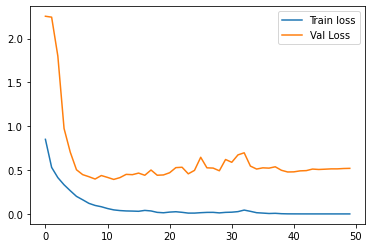

In [25]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

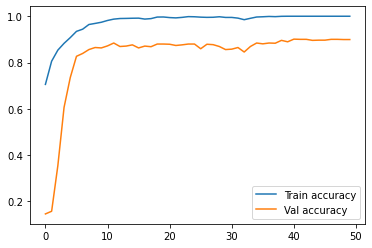

In [26]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

In [27]:
# predicting on test data.
pred_test = model.predict(X_test_exp)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

36/36 [==============================] - 1s 20ms/step


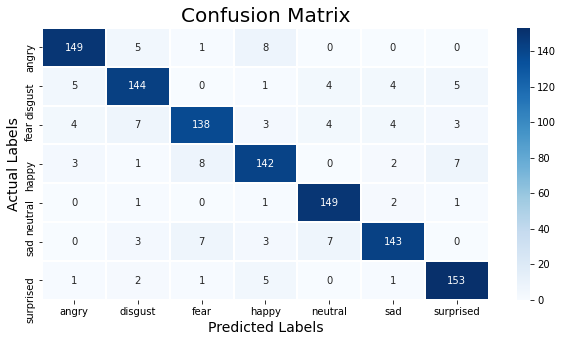

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.92      0.91      0.92       163
     disgust       0.88      0.88      0.88       163
        fear       0.89      0.85      0.87       163
       happy       0.87      0.87      0.87       163
     neutral       0.91      0.97      0.94       154
         sad       0.92      0.88      0.90       163
   surprised       0.91      0.94      0.92       163

    accuracy                           0.90      1132
   macro avg       0.90      0.90      0.90      1132
weighted avg       0.90      0.90      0.90      1132



## Check some misclassified emotions

In [30]:
df_test["predict"] = y_pred

In [31]:
df_test.shape

(1132, 187)

In [43]:
df_miss = df_test[df_test["label"] != df_test["predict"]][["file","label", "predict"]]
df_miss = df_miss.reset_index()



df_miss.head(20)

,index,file,label,predict
0,4,./raw_source/RAVDESS/Actor_11/03-01-04-02-01-0...,sad,fear
1,18,./raw_source/RAVDESS/Actor_15/03-01-06-01-02-0...,fear,disgust
2,23,./raw_source/RAVDESS/Actor_20/03-01-07-01-01-0...,disgust,angry
3,27,./raw_source/RAVDESS/Actor_22/03-01-04-01-01-0...,sad,neutral
4,35,./raw_source/RAVDESS/Actor_11/03-01-03-02-01-0...,happy,angry
5,37,./raw_source/RAVDESS/Actor_10/03-01-05-01-02-0...,angry,disgust
6,61,./raw_source/RAVDESS/Actor_01/03-01-05-02-02-0...,angry,fear
7,95,./raw_source/Savee/KL/sa09.wav,sad,neutral
8,109,./raw_source/RAVDESS/Actor_23/03-01-03-01-02-0...,happy,surprised
9,110,./raw_source/RAVDESS/Actor_04/03-01-06-02-01-0...,fear,happy


In [33]:
def play_librosa(wav_file, source='None'):
    
    print("WAV: ", wav_file)
    
    audio, sfreq = librosa.load(wav_file)
    time = np.arange(0, len(audio)) / sfreq

    print('Sample Rate:', sfreq)
    
    fig, ax = plt.subplots()
    ax.plot(time, audio)
    ax.set(xlabel='Time (sec)',  ylabel='Sound Amplitude')

    return Audio(data=audio, rate=sfreq)

Actual is happy Predicted as fear
WAV:  ./raw_source/RAVDESS/Actor_18/03-01-03-02-02-01-18.wav
Sample Rate: 22050


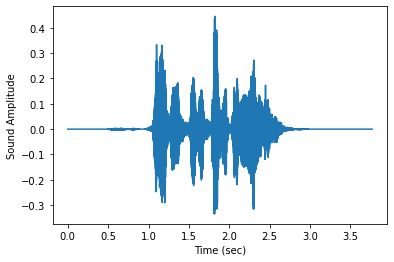

In [44]:
print(f'Actual is {df_miss.iloc[35]["label"]} Predicted as {df_miss.iloc[35]["predict"]}')
play_librosa(df_miss.iloc[35]["file"])

Actual is surprised Predicted as happy
WAV:  ./raw_source/RAVDESS/Actor_01/03-01-08-02-01-01-01.wav
Sample Rate: 22050


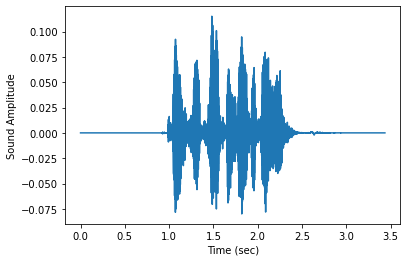

In [41]:
print(f'Actual is {df_miss.iloc[110]["label"]} Predicted as {df_miss.iloc[110]["predict"]}')
play_librosa(df_miss.iloc[110]["file"])

Actual is angry Predicted as happy
WAV:  ./raw_source/RAVDESS/Actor_15/03-01-05-02-02-01-15.wav
Sample Rate: 22050


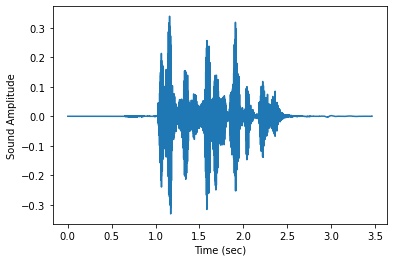

In [40]:
print(f'Actual is {df_miss.iloc[112]["label"]} Predicted as {df_miss.iloc[112]["predict"]}')
play_librosa(df_miss.iloc[112]["file"])

## SAVING THE MODEL and Testing

In [38]:
#save the model
model.save("./model/tf_ser_final.h5")

# save the scaler
joblib.dump(scaler, './model/tf_ser_std_scaler.bin', compress=True)

# save the encoder
joblib.dump(encoder, './model/tf_ser_encoder.bin', compress=True)


['./model/tf_ser_encoder.bin']

## 7. SUMMARY

The model achieve a remarkable Accuracy of 90%! Happy has the lowest Precision of 87% and fear with lowest Recall of 85%. I listened to the wrong predictions, and it is really a challenge even for human to predict the actual emotion.